<a href="https://colab.research.google.com/github/hg277804/Human_Activity_Recognition/blob/main/Group4_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Install Dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark


In [ ]:
# Add environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"
os.environ["SPARK_HOME"] = "spark-3.5.0-bin-hadoop3"

# initilize pyspark using findspark
import findspark
findspark.init()

# create the spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
# Mount Goodle Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import libraries
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

##  Extract, Transform, and Load the data for Classification
1. Create a function to create a data frame for each file
2. Create a function to join data frames
3. Label the joined training and testing data frames.


In [ ]:
#function to get the file names for the training and testng group
def get_files(type_):

  filenames = list()
  filenames += ['total_acc_x_'+ type_ +'.csv', 'total_acc_y_'+ type_ + '.csv', 'total_acc_z_'+ type_ + '.csv']
  # body acceleration
  filenames += ['body_acc_x_'+ type_ + '.csv', 'body_acc_y_'+ type_ +'.csv', 'body_acc_z_'+ type_ + '.csv']
  # body gyroscope
  filenames += ['body_gyro_x_'+ type_ +'.csv', 'body_gyro_y_'+ type_ +'.csv', 'body_gyro_z_'+ type_ +'.csv']
  # load input data
  return(filenames)

# function for making a data frame for each file
def make_df( name, type_ , part):

  # get the file path
  path = '/content/gdrive/MyDrive/516/516_Project/UCI HAR Dataset/csv_' + type_ + '/' + name
  df = spark.read.csv(path, header=True, inferSchema=True)

  # List of columns to be unique to file
  new_cols = [name[0:12]+str(i) for i in range(1, len(df.columns) +1)]

  # Rename dataframe columns so they are unique to the file
  df = df.toDF(*new_cols)

  # Get the number of columns for indexing - this will help get us a moving window to train
  col_num = [column.name for column in df.schema.fields[0:(64 + part)]]

  return(df.select(col_num).withColumn("id", F.monotonically_increasing_id()))

def make_pd_df( name, type_, part ):

  # get the file path
  path = '/content/gdrive/MyDrive/516/516_Project/UCI HAR Dataset/csv_' + type_ + '/' + name
  df = pd.read_csv(path)

  # rename columns to be unique to file
  new_cols = [name[0:12]+str(i) for i in range(1, df.shape[1] + 1)]

  # Rename dataframe columns so they are unique to the file
  df = df.set_axis(new_cols, axis = 'columns')

  #Get the number of columns for indexing - this will help get us a moving window to train
  df = df[new_cols[0:part]]
  df['id'] = np.arange(df.shape[0])

  return(spark.createDataFrame(df))

# function to join data frames
def join_stuff(df1, df2):
  df = df1.join((df2), df1.id == df2.id, 'left').drop(df2.id)
  return(df)

# make a function to iteratively call the joining function for all 9 training and test files.
def all_dims_df (type_, part):
  files = get_files(type_)
  for i in range(0, len(files)-1):
    if i == 0:
      df = join_stuff(make_pd_df(files[i], type_, part), make_pd_df(files[i+1], type_, part))
    else:
      df = join_stuff(df, make_pd_df(files[i+1], type_, part))
  return(df)

# Join dataframes to get labels and features together
def join_labels(df1, df2):
  df = df1.join(df2, df1.id == df2.id, 'left').drop(df2.id)

  # We need to get ride of the id column we used to join before selecting features
  return(df.drop(df1.id))

# create a function to prepare data for the classifier
def vec_scal(df):
  # Vectorize features
  f_cols = df.columns[1:]

  assemble = VectorAssembler(inputCols = f_cols, outputCol='features', handleInvalid ='keep')
  asem_data = assemble.transform(df).select('label', 'features')

  # scale data for classifer
  #scaler = MinMaxScaler(inputCol='assembled_features', outputCol= 'features')
  #scal_data = scaler.fit(asem_data).transform(asem_data)

  return(asem_data.select('label', 'features'))

# Evaluate the model:
def eval(model_type, df, frames):
  # initialize lists to hold evaluation data
  Model = []
  Window_In_Seconds = []
  Evaluation_Type = []
  metric_value = []

  # create a dataframe with predictions and labels
  df = df.select('prediction', 'label')
  metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
  for metric in metrics:

    # get the model name
    Model.append(model_type)

    # get the metric name
    Evaluation_Type.append(metric)

    # Get time frame used to train model
    minutes = frames * (2.58/128)
    Window_In_Seconds.append(minutes)

    # create evaluator for the metric
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    # get the metric value
    value_ = evaluator.evaluate(df)
    metric_value.append(value_)

  eval_df = pd.DataFrame({'Model': Model, 'Window_In_Seconds': Window_In_Seconds, 'Evaluation_Type': Evaluation_Type, 'metric_value': metric_value})
  return(eval_df)

In [ ]:
# Read in training and test datasets to see is missing data needs to be imputed

# function for making an RDD and looking at null values
def check_cnt(name, type_ ):

  # get the file path
  path = '/content/gdrive/MyDrive/516/516_Project/UCI HAR Dataset/csv_' + type_ + '/' + name
  d = sc.textFile(path)

  # checking for nulls:
  rdd = d.map(lambda x: (x.split(","))).map(lambda x: ([i for i in x if x != ""])).filter(lambda x: len(x) == 128)
  return(print ("file ", name, "has", rdd.count(), "good rows" )) #should be 7352 for training and 2947 for test

files = get_files('train')
for name in files:
  check_cnt(name, 'train')

files = get_files('test')
for name in files:
  check_cnt(name, 'test')

file  total_acc_x_train.csv has 7353 good rows
file  total_acc_y_train.csv has 7353 good rows
file  total_acc_z_train.csv has 7353 good rows
file  body_acc_x_train.csv has 7353 good rows
file  body_acc_y_train.csv has 7353 good rows
file  body_acc_z_train.csv has 7353 good rows
file  body_gyro_x_train.csv has 7353 good rows
file  body_gyro_y_train.csv has 7353 good rows
file  body_gyro_z_train.csv has 7353 good rows
file  total_acc_x_test.csv has 2948 good rows
file  total_acc_y_test.csv has 2948 good rows
file  total_acc_z_test.csv has 2948 good rows
file  body_acc_x_test.csv has 2948 good rows
file  body_acc_y_test.csv has 2948 good rows
file  body_acc_z_test.csv has 2948 good rows
file  body_gyro_x_test.csv has 2948 good rows
file  body_gyro_y_test.csv has 2948 good rows
file  body_gyro_z_test.csv has 2948 good rows


In [ ]:
# create a dataframe with all test data - from three sensor cats and three dimensions
all_test = all_dims_df('test', 96)
all_test.show()

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---

In [ ]:
# call the all_dim_df function to get all sensors and their dimensions in one flat data frame
all_train = all_dims_df('train', 96)
all_train.show()

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---

In [ ]:
# Read in training Labels and create ID column to join data
# All 6 values were changed to 0.
path11 = '/content/gdrive/MyDrive/516/516_Project/UCI HAR Dataset/y_train.csv'
lab_train = spark.read.csv(path11, header=False, inferSchema=True)\
                                .withColumnRenamed('_c0', 'label')\
                                .withColumn("id", F.monotonically_increasing_id())

lab_train.show(10)

# Make the labels numeric for the model fitting
for col in lab_train .columns:
    lab_train  = lab_train.withColumn(col, lab_train[col].cast('int'))

# Read in testing Labels and create ID column to join data
path12 = '/content/gdrive/MyDrive/516/516_Project/UCI HAR Dataset/y_test.csv'
lab_test = spark.read.csv(path12, header=False, inferSchema=True)\
                                .withColumnRenamed('_c0', 'label')\
                                .withColumn("id", F.monotonically_increasing_id())

lab_test.show(10)
# Make the labels numeric for the model fitting
for col in lab_test.columns:
    lab_test  = lab_test.withColumn(col, lab_test[col].cast('int'))

lab_train.select('label').count()  #7352
#lab_test.select('label').count()  #2947

+-----+---+
|label| id|
+-----+---+
|    5|  0|
|    5|  1|
|    5|  2|
|    5|  3|
|    5|  4|
|    5|  5|
|    5|  6|
|    5|  7|
|    5|  8|
|    5|  9|
+-----+---+
only showing top 10 rows

+-----+---+
|label| id|
+-----+---+
|    5|  0|
|    5|  1|
|    5|  2|
|    5|  3|
|    5|  4|
|    5|  5|
|    5|  6|
|    5|  7|
|    5|  8|
|    5|  9|
+-----+---+
only showing top 10 rows



7352

In [ ]:
# call the function to join labels to features
labeled_train = join_labels(lab_train, all_train)
labeled_test = join_labels(lab_test, all_test)

labeled_train.show(10)
labeled_test.show(10)


+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+------------

In [ ]:
len(labeled_train.columns)

865

##  Train the multi-perceptron Classifier
1. Create a vector of features for training
2. Tune the model parameters
3. Train the model
4. Evaluate the model performance

In [ ]:
# create a function to prepare data for the classifier

def vec_scal(df):
  # Vectorize features
  f_cols = df.columns[1:]

  assemble = VectorAssembler(inputCols = f_cols, outputCol='features', handleInvalid ='keep')
  asem_data = assemble.transform(df).select('label', 'features')

  # scale data for classifer
  #scaler = MinMaxScaler(inputCol='assembled_features', outputCol= 'features')
  #scal_data = scaler.fit(asem_data).transform(asem_data)
  return(asem_data.select('label', 'features'))


# Get the scaled feature vector for training data
train_data = vec_scal(labeled_train)
train_data.show(10)

# Get the scaled feature vector for test data
test_data = vec_scal(labeled_test)
test_data.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    5|[1.012817,1.02283...|
|    5|[1.018851,1.02238...|
|    5|[1.021278,1.01887...|
|    5|[1.016458,1.01608...|
|    5|[1.023996,1.02448...|
|    5|[1.019289,1.01923...|
|    5|[1.025473,1.01949...|
|    5|[1.010311,1.00987...|
|    5|[1.009916,1.00969...|
|    5|[1.010144,1.01059...|
+-----+--------------------+
only showing top 10 rows

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    5|[1.041216,1.04180...|
|    5|[0.9991921,0.9946...|
|    5|[0.9897341,0.9875...|
|    5|[0.989642,0.98840...|
|    5|[0.9897889,0.9880...|
|    5|[0.9895114,0.9921...|
|    5|[0.9915353,0.9933...|
|    5|[0.9628812,0.9620...|
|    5|[0.9670527,0.9659...|
|    5|[0.946919,0.95188...|
+-----+--------------------+
only showing top 10 rows



## Parameter Tuning for the Classification Models

In [ ]:
# Create a function to determine best layer values for MLP classifer
def tuning(train_data, test_data, frames = 96):
  for i in [40, 45, 50, 55, 60, 65, 70, 75, 80]:
    for j in [40, 45, 50, 55, 60, 65, 70, 75, 80]:

       # Create the multilayer Perceptron Classifier
      mlpc = MultilayerPerceptronClassifier(labelCol = 'label', featuresCol= 'features', layers = [frames*9, i, j, 6],\
        maxIter=100, blockSize = 128, seed = 3)

    # fit the model to the training data
      ann = mlpc.fit(train_data)

    # Get test predictions for models
      predictions = ann.transform(test_data)
      if i == 40 and j == 40:

    # get the precision, recall and accuracy of results
        results = eval('Multilayer Perceptron Classifier', predictions, frames)

      else:
        results = results.append(eval('Multilayer Perceptron Classifier', predictions, frames))


  return (results)

param_tun = tuning(train_data, test_data)


<ipython-input-11-aa2a81c03cac>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(eval('Multilayer Perceptron Classifier', predictions, frames))
<ipython-input-11-aa2a81c03cac>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(eval('Multilayer Perceptron Classifier', predictions, frames))
<ipython-input-11-aa2a81c03cac>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(eval('Multilayer Perceptron Classifier', predictions, frames))
<ipython-input-11-aa2a81c03cac>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(eval('Multilayer Perceptron

In [ ]:
# create layer values to append to the MLP result dataframe
Second_ = []
Third_ = []
for i in [40, 45, 50, 55, 60, 65, 70, 75, 80]:
  for j in [40, 45, 50, 55, 60, 65, 70, 75, 80]:
    two = [i,i,i]
    three = [j,j,j]
    Second_.append(two)
    Third_.append(three)

Second_Layer = [item for sublist in Second_ for item in sublist]
Third_Layer = [item for sublist in Third_ for item in sublist]

# Add the layer values to select the best value
param_tun['Second_Layer'] = Second_Layer
param_tun['Third_Layer'] = Third_Layer

# the finished data
MLP_acc = param_tun.loc[param_tun['Evaluation_Type'] == 'accuracy']
MLP_recal = param_tun.loc[param_tun['Evaluation_Type'] == 'weightedRecall']
MLP_prec = param_tun.loc[param_tun['Evaluation_Type'] == 'weightedPrecision']

param_tun

,Model,Window_In_Seconds,Evaluation_Type,metric_value,Second_Layer,Third_Layer
0,Multilayer Perceptron Classifier,1.935,weightedPrecision,0.723378,40,40
1,Multilayer Perceptron Classifier,1.935,weightedRecall,0.716661,40,40
2,Multilayer Perceptron Classifier,1.935,accuracy,0.716661,40,40
0,Multilayer Perceptron Classifier,1.935,weightedPrecision,0.732785,40,45
1,Multilayer Perceptron Classifier,1.935,weightedRecall,0.728198,40,45
...,...,...,...,...,...,...
1,Multilayer Perceptron Classifier,1.935,weightedRecall,0.734985,80,75
2,Multilayer Perceptron Classifier,1.935,accuracy,0.734985,80,75
0,Multilayer Perceptron Classifier,1.935,weightedPrecision,0.723357,80,80
1,Multilayer Perceptron Classifier,1.935,weightedRecall,0.712250,80,80


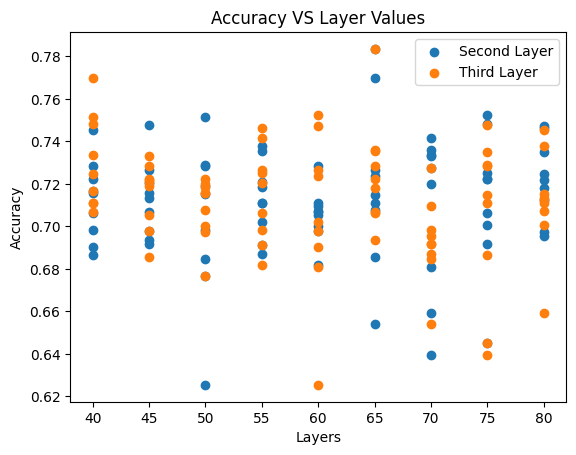

In [ ]:
# write a function to plot the metrics
def plot_stuff(df, metric):


  x1 = df['Second_Layer']
  y1 = df['metric_value']
  # plotting the line 1 points
  plt.scatter(x1, y1, label = "Second Layer")

  # line 2 points
  x2 = df['Third_Layer']
  y2 = df['metric_value']
  # plotting the line 2 points
  plt.scatter(x2, y2, label = "Third Layer")

  # naming the x axis
  plt.xlabel('Layers')
  # naming the y axis
  plt.ylabel(metric)
  # giving a title to my graph
  plt.title( metric + ' VS Layer Values')

  # show a legend on the plot
  plt.legend()

  # function to show the plot
  plt.show()

plot_stuff(MLP_acc, "Accuracy")

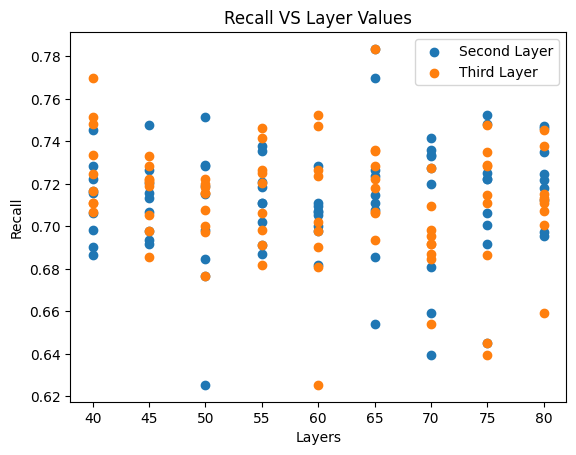

In [ ]:
# Plot the recall value for different layer values
plot_stuff(MLP_recal, 'Recall')

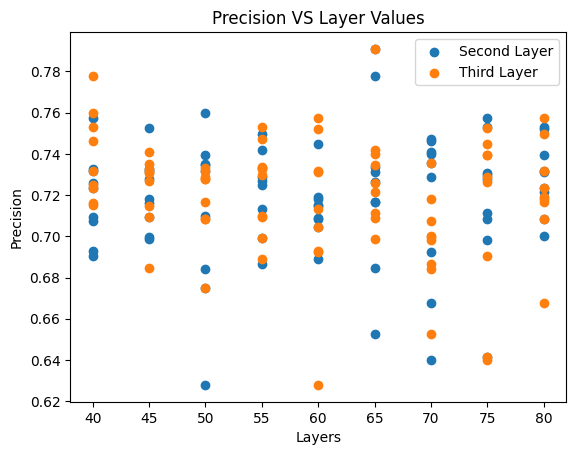

In [ ]:
# Plot the precision values for different layer values
plot_stuff(MLP_prec, 'Precision')

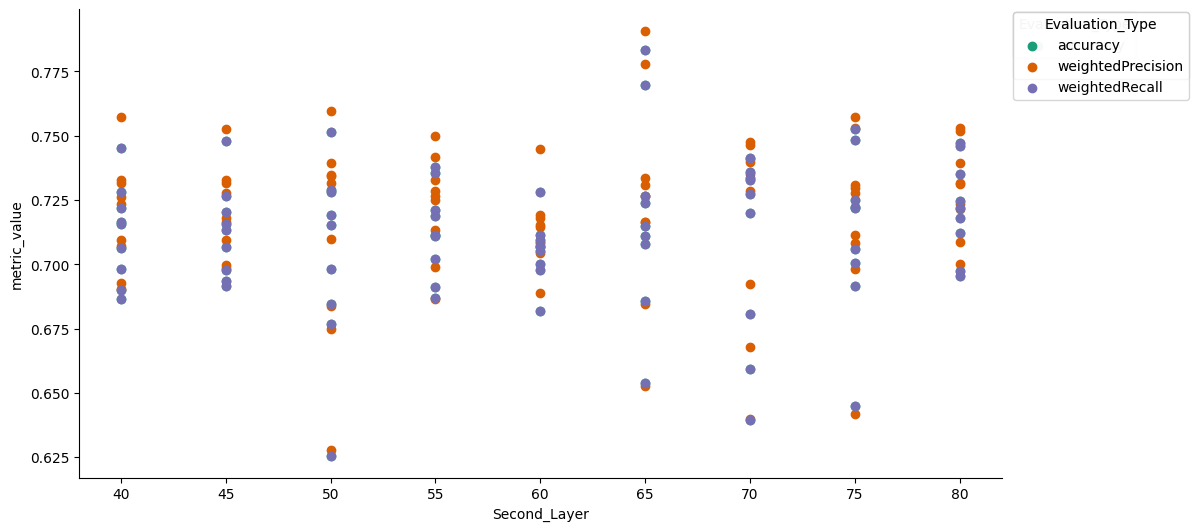

In [ ]:
# Second Layer vs Metrics
def _plot_series(series, series_name, series_index=0):

  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Second_Layer']
  ys = series['metric_value']

  plt.scatter(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = param_tun.sort_values('Second_Layer', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Evaluation_Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Evaluation_Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Second_Layer')
_ = plt.ylabel('metric_value')

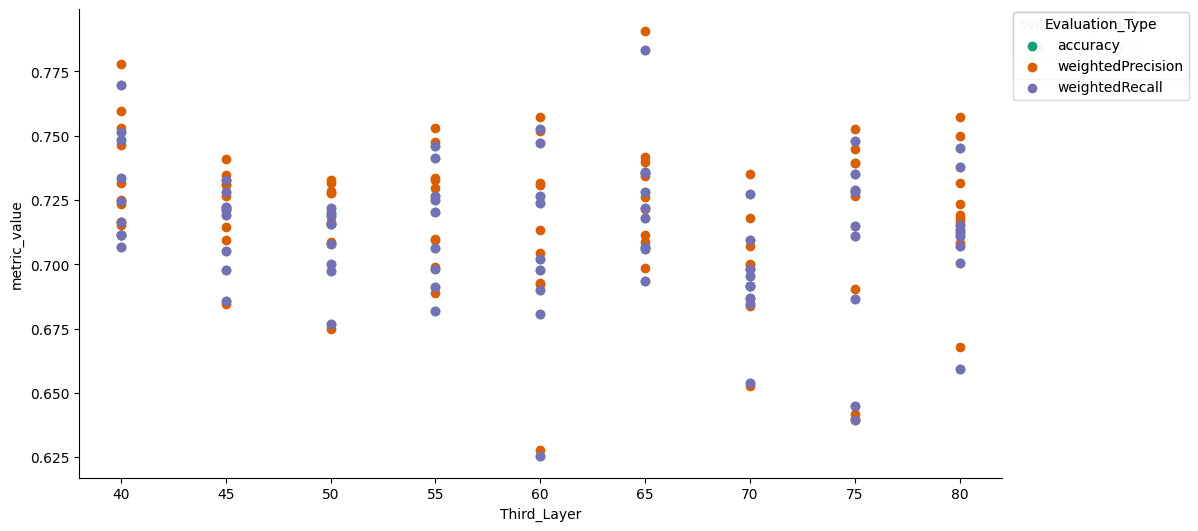

In [ ]:
# Third Layer vs Metrics
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Third_Layer']
  ys = series['metric_value']

  plt.scatter(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = param_tun.sort_values('Third_Layer', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Evaluation_Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Evaluation_Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Third_Layer')
_ = plt.ylabel('metric_value')

In [ ]:
def tuning2(train_data, test_data, frames = 96 ):
  for i in [10,15,20,25,30,35]:

  # Create the radom forest classifier
      rfc1= RandomForestClassifier(numTrees=i, maxDepth=10, labelCol = "label", seed=42,
      leafCol="leafId")

     # fit the model to the training data
      rfc = rfc1.fit(train_data)

      # Get test predictions for models
      predictions2 = rfc.transform(test_data)

      if i == 10:
      # get the precision, recall and accuracy of results
        results2 = eval('Random Forest Classifier', predictions2, frames)

      else:
        results2 = results2.append(eval('Random Forest Classifier', predictions2, frames))


  return (results2)

rand_forst_tun = tuning2(train_data, test_data )



In [ ]:
# Create the column of tree values to append to the results dataframe
num_trees = []
for i in [10,15,20,25,30,35]:
  trees = [i,i,i]
  num_trees.append(trees)

# Unlist the sublists
num_trees = [item for sublist in num_trees for item in sublist]

# Add the layer values to select the best value
rand_forst_tun['Number_Trees'] = num_trees

# the finished data partitioned by metric value
RF_NUM_TREE_acc = rand_forst_tun.loc[rand_forst_tun['Evaluation_Type'] == 'accuracy']
RF_NUM_TREE_recal = rand_forst_tun.loc[rand_forst_tun['Evaluation_Type'] == 'weightedRecall']
RF_NUM_TREE_prec = rand_forst_tun.loc[rand_forst_tun['Evaluation_Type'] == 'weightedPrecision']
#rand_forst_tun

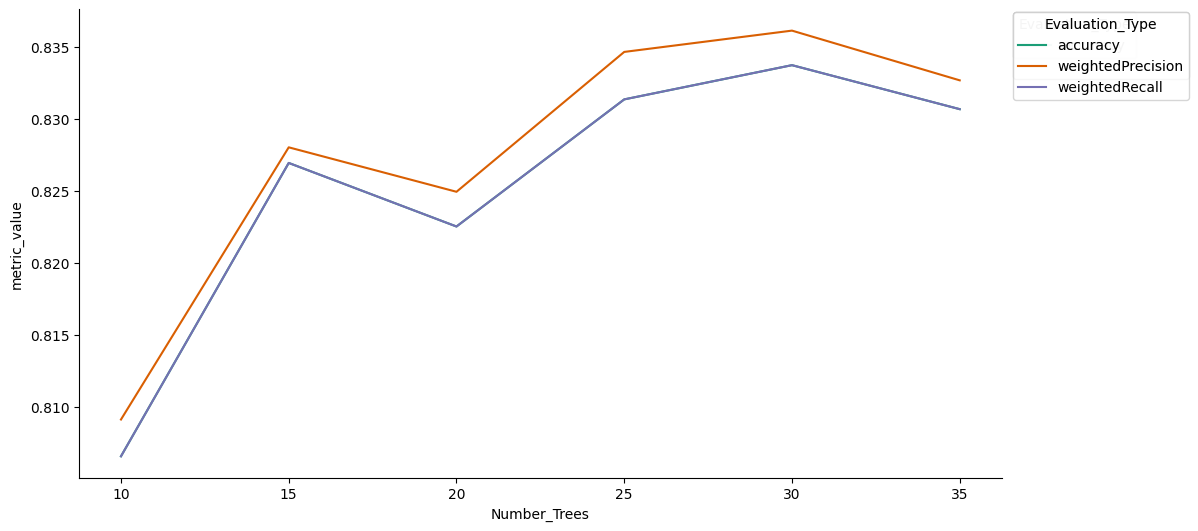

In [ ]:

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Number_Trees']
  ys = series['metric_value']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rand_forst_tun.sort_values('Number_Trees', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Evaluation_Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Evaluation_Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Number_Trees')
_ = plt.ylabel('metric_value')

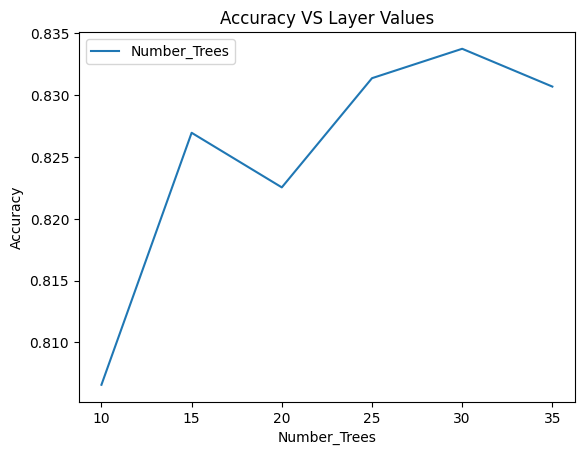

In [ ]:
# write a function to plot the metrics - The accuracy followed Recall too closesly to see on first graph
def plot_trees(df, metric):


  x1 = df['Number_Trees']
  y1 = df['metric_value']
  # plotting the line 1 points
  plt.plot(x1, y1, label = "Number_Trees")

   # naming the x axis
  plt.xlabel('Number_Trees')
  # naming the y axis
  plt.ylabel(metric)
  # giving a title to my graph
  plt.title( metric + ' VS Layer Values')

  # show a legend on the plot
  plt.legend()

  # function to show the plot
  plt.show()

plot_trees(RF_NUM_TREE_acc, "Accuracy")

In [ ]:
def tuning_dep(train_data, test_data, frames = 96 ):
  for i in [10,15,20,25,30]:

  # Create the radom forest classifier
      rfc1= RandomForestClassifier(numTrees=35, maxDepth=i, labelCol = "label", seed=42,
      leafCol="leafId")

     # fit the model to the training data
      rfc = rfc1.fit(train_data)

      # Get test predictions for models
      predictions2 = rfc.transform(test_data)

      if i == 10:
      # get the precision, recall and accuracy of results
        results2 = eval('Random Forest Classifier', predictions2, frames)

      else:
        results2 = results2.append(eval('Random Forest Classifier', predictions2, frames))


  return (results2)

rand_forst_dep = tuning_dep(train_data, test_data )

<ipython-input-47-8ecee92f3354>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results2 = results2.append(eval('Random Forest Classifier', predictions2, frames))
<ipython-input-47-8ecee92f3354>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results2 = results2.append(eval('Random Forest Classifier', predictions2, frames))
<ipython-input-47-8ecee92f3354>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results2 = results2.append(eval('Random Forest Classifier', predictions2, frames))
<ipython-input-47-8ecee92f3354>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results2 = results2.append(eval('Random Forest Classifier', predict

In [ ]:
# Create the column of tree values to append to the results dataframe
depth = []
for i in [10,15,20,25,30]:
  deep = [i,i,i]
  depth.append(deep)

# Unlist the sublists
depth = [item for sublist in depth for item in sublist]

# Add the layer values to select the best value
rand_forst_dep['Max_Depth'] = depth

# the finished data partitioned by metric value
RF_DEP_TREE_acc = rand_forst_dep.loc[rand_forst_dep['Evaluation_Type'] == 'accuracy']
RFDEP_TREE_recal = rand_forst_dep.loc[rand_forst_dep['Evaluation_Type'] == 'weightedRecall']
RF_DEP_TREE_prec = rand_forst_dep.loc[rand_forst_dep['Evaluation_Type'] == 'weightedPrecision']
rand_forst_dep


,Model,Window_In_Minutes,Evaluation_Type,metric_value,Max_Depth
0,Random Forest Classifier,1.935,weightedPrecision,0.832676,10
1,Random Forest Classifier,1.935,weightedRecall,0.830675,10
2,Random Forest Classifier,1.935,accuracy,0.830675,10
0,Random Forest Classifier,1.935,weightedPrecision,0.844826,15
1,Random Forest Classifier,1.935,weightedRecall,0.844248,15
2,Random Forest Classifier,1.935,accuracy,0.844248,15
0,Random Forest Classifier,1.935,weightedPrecision,0.839112,20
1,Random Forest Classifier,1.935,weightedRecall,0.838480,20
2,Random Forest Classifier,1.935,accuracy,0.838480,20
0,Random Forest Classifier,1.935,weightedPrecision,0.838154,25


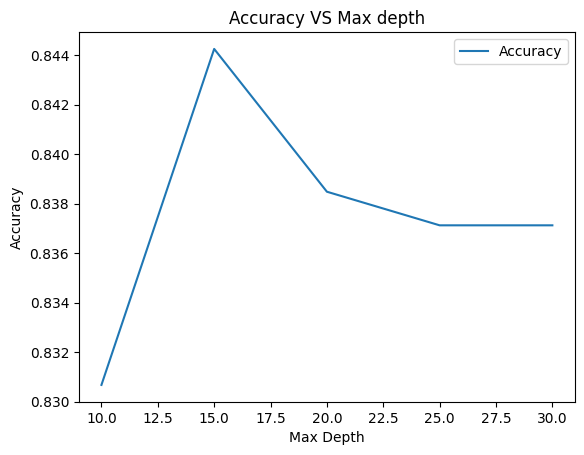

In [ ]:
# write a function to plot the metrics
def plot_dep(df, metric):

  # get x and y values to graph
  x1 = df['Number_Trees']
  y1 = df['metric_value']
  # plotting the line 1 points
  plt.plot(x1, y1, label = metric)

  # naming the x axis
  plt.xlabel('Max Depth')
  # naming the y axis
  plt.ylabel(metric)
  # giving a title to my graph
  plt.title( metric + ' VS Max depth')

  # show a legend on the plot
  plt.legend()

  # function to show the plot
  plt.show()

plot_dep(RF_DEP_TREE_acc, "Accuracy")

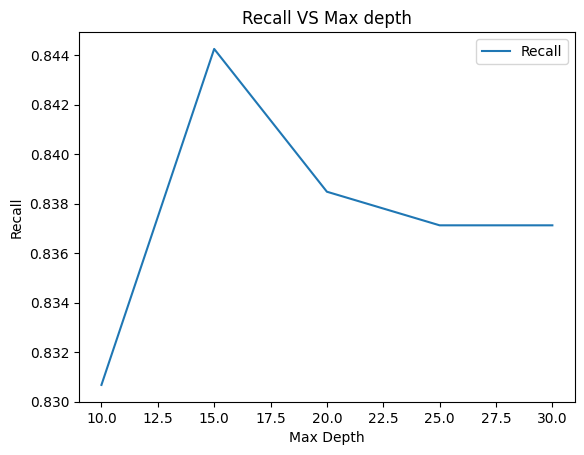

In [ ]:
plot_dep(RFDEP_TREE_recal, "Recall")


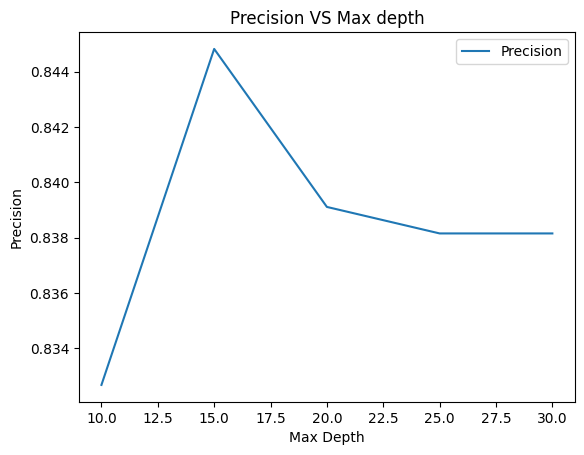

In [ ]:
plot_dep(RF_DEP_TREE_prec, "Precision")

## Run the Tuned Models for various "window sizes"
Return analysis time for merging data and running each model

In [ ]:
def find_window(lab_train, lab_test, frames):
  # Call the all_dim_df function to get all sensors and their dimensions for training and testing data

  # Get start time for data processing
  start = time.time()

  # Get the training and testing data
  all_train = all_dims_df('train', frames)
  all_test = all_dims_df('test', frames)

  # call the function to join labels to features
  labeled_train = join_labels(lab_train, all_train)
  labeled_test = join_labels(lab_test, all_test)

  # Get the scaled feature vector for training data
  train_data = vec_scal(labeled_train)
  test_data = vec_scal(labeled_test)

  #end time for data processing
  end = time.time()
  data_time = end - start

  start = time.time()
  # Create the multilayer Perceptron Classifier
  mlpc = MultilayerPerceptronClassifier(labelCol = 'label', featuresCol= 'features', layers = [frames*9, 65, 65, 6],\
      maxIter=100, blockSize = 128, seed = 3)

  # fit the model to the training data
  ann = mlpc.fit(train_data)

  # Capture time to train MLP
  end = time.time()
  mlp_time = end - start

  start = time.time()
  # Create the radom forest classifier
  rfc1 = RandomForestClassifier(numTrees=30, maxDepth=15, labelCol = "label", seed = 42,
    leafCol="leafId")

  # fit the model to the training data
  rfc = rfc1.fit(train_data)

  # Capture time to train random forest classifier
  end = time.time()
  rfc_time = end - start

  # Get test predictions for models
  predictions = ann.transform(test_data)
  predictions2 = rfc.transform(test_data)

  # get the precision, recall and accuracy of results
  results1 = eval('Multilayer Perceptron Classifier', predictions, frames)
  results2 = eval('Random Forest Classifier', predictions2, frames)

  result = results1.append(results2)
  result['RFC training time'] = rfc_time
  result['Data processing time'] = data_time
  result['MLP training time'] = mlp_time

  return(result)


# iterate through frame nubers:
lst = [66, 76 ,86, 96, 106, 116, 128]




In [ ]:
df = find_window(lab_train, lab_test, 66)
df

<ipython-input-7-821cb683de8a>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = results1.append(results2)


,Model,Window_In_Seconds,Evaluation_Type,metric_value,RFC training time,Data processing time,MLP training time
0,Multilayer Perceptron Classifier,1.330313,weightedPrecision,0.712256,118.532387,45.570947,103.98512
1,Multilayer Perceptron Classifier,1.330313,weightedRecall,0.705124,118.532387,45.570947,103.98512
2,Multilayer Perceptron Classifier,1.330313,accuracy,0.705124,118.532387,45.570947,103.98512
0,Random Forest Classifier,1.330313,weightedPrecision,0.855073,118.532387,45.570947,103.98512
1,Random Forest Classifier,1.330313,weightedRecall,0.854768,118.532387,45.570947,103.98512
2,Random Forest Classifier,1.330313,accuracy,0.854768,118.532387,45.570947,103.98512


In [ ]:
df2 = find_window(lab_train, lab_test, 76)
df2

<ipython-input-19-821cb683de8a>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = results1.append(results2)


,Model,Window_In_Seconds,Evaluation_Type,metric_value,RFC training time,Data processing time,MLP training time
0,Multilayer Perceptron Classifier,1.531875,weightedPrecision,0.737719,150.471989,57.166572,104.25828
1,Multilayer Perceptron Classifier,1.531875,weightedRecall,0.727859,150.471989,57.166572,104.25828
2,Multilayer Perceptron Classifier,1.531875,accuracy,0.727859,150.471989,57.166572,104.25828
0,Random Forest Classifier,1.531875,weightedPrecision,0.846729,150.471989,57.166572,104.25828
1,Random Forest Classifier,1.531875,weightedRecall,0.845266,150.471989,57.166572,104.25828
2,Random Forest Classifier,1.531875,accuracy,0.845266,150.471989,57.166572,104.25828


In [ ]:
df3 = find_window(lab_train, lab_test, 86)
df3

/bin/bash: line 1: spark-submit: command not found


<ipython-input-13-9f2b5be557dd>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = results1.append(results2)


,Model,Window_In_Minutes,Evaluation_Type,metric_value,RFC training time,Data processing time,MLP training time
0,Multilayer Perceptron Classifier,1.733437,weightedPrecision,0.741167,278.420608,66.996111,199.762787
1,Multilayer Perceptron Classifier,1.733437,weightedRecall,0.736342,278.420608,66.996111,199.762787
2,Multilayer Perceptron Classifier,1.733437,accuracy,0.736342,278.420608,66.996111,199.762787
0,Random Forest Classifier,1.733437,weightedPrecision,0.848794,278.420608,66.996111,199.762787
1,Random Forest Classifier,1.733437,weightedRecall,0.847981,278.420608,66.996111,199.762787
2,Random Forest Classifier,1.733437,accuracy,0.847981,278.420608,66.996111,199.762787


In [ ]:
df4 = find_window(lab_train, lab_test, 96)
df4

<ipython-input-7-6d6434815578>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = results1.append(results2)


,Model,Window_In_Minutes,Evaluation_Type,metric_value
0,Multilayer Perceptron Classifier,1.935000,weightedPrecision,0.790869
1,Multilayer Perceptron Classifier,1.935000,weightedRecall,0.783509
2,Multilayer Perceptron Classifier,1.935000,accuracy,0.783509
0,Random Forest Classifier,1.935000,weightedPrecision,0.849050
1,Random Forest Classifier,1.935000,weightedRecall,0.846963
2,Random Forest Classifier,1.935000,accuracy,0.846963
RFC training time,204.322461,204.322461,204.322461,204.322461
Data processing time,85.803353,85.803353,85.803353,85.803353
MLP training time,165.335979,165.335979,165.335979,165.335979


In [ ]:
df5 = find_window(lab_train, lab_test, 106)
df5

<ipython-input-7-6d6434815578>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = results1.append(results2)


,Model,Window_In_Minutes,Evaluation_Type,metric_value
0,Multilayer Perceptron Classifier,2.580000,weightedPrecision,0.756920
1,Multilayer Perceptron Classifier,2.580000,weightedRecall,0.747201
2,Multilayer Perceptron Classifier,2.580000,accuracy,0.747201
0,Random Forest Classifier,2.580000,weightedPrecision,0.846759
1,Random Forest Classifier,2.580000,weightedRecall,0.845945
2,Random Forest Classifier,2.580000,accuracy,0.845945
RFC training time,234.808546,234.808546,234.808546,234.808546
Data processing time,137.882538,137.882538,137.882538,137.882538
MLP training time,198.049355,198.049355,198.049355,198.049355


In [ ]:
df6 = find_window(lab_train, lab_test, 116)
df6

<ipython-input-9-95f3da056589>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = results1.append(results2)


,Model,Window_In_Minutes,Evaluation_Type,metric_value,RFC training time,Data processing time,MLP training time
0,Multilayer Perceptron Classifier,2.136563,weightedPrecision,0.737505,184.16669,82.810969,139.618384
1,Multilayer Perceptron Classifier,2.136563,weightedRecall,0.727520,184.16669,82.810969,139.618384
2,Multilayer Perceptron Classifier,2.136563,accuracy,0.727520,184.16669,82.810969,139.618384
0,Random Forest Classifier,2.136563,weightedPrecision,0.845540,184.16669,82.810969,139.618384
1,Random Forest Classifier,2.136563,weightedRecall,0.844248,184.16669,82.810969,139.618384
2,Random Forest Classifier,2.136563,accuracy,0.844248,184.16669,82.810969,139.618384


In [ ]:
df7 = find_window(lab_train, lab_test, 128)
df7

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 43460)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-f683b0dac5b6>", line 1, in <cell line: 1>
    df7 = find_window(lab_train, lab_test, 128)
  File "<ipython-input-7-821cb683de8a>", line 41, in find_window
    rfc = rfc1.fit(train_data)
  File "/content/spark-3.5.0-bin-hadoop3/python/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/content/spark-3.5.0-bin-hadoop3/python/pyspark/ml/wrapper.py", line 381, in _fit
    java_model = self._fit_java(dataset)
  File "/content/spark-3.5.0-bin-hadoop3/python/pyspark/ml/wrapper.py", line 378, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "spark-3.5.0-bin-hadoop3/python/lib/py4j-

Py4JError: ignored

In [ ]:
tot = df.append(df2)
tot = tot.append(df3)
tot = tot.append(df4)
tot = tot.append(df5)
tot = tot.append(df6)
tot = tot.append(df7)

tot.to_csv('/content/gdrive/My Drive/classifier_metrx5.csv', sep=',')


# Visualize the metrics and run-time for each window

In [ ]:
# read in file that was created with merged outputs
fin_data = pd.read_csv('/content/gdrive/MyDrive/516/516_Project/classifier_metrics.csv')

# get subset of data
def sub_data(df, model, eval_type):
  df = df.loc[df['Model'] == model]
  df = df.loc[df['Evaluation_Type'] == eval_type]

  return(df)

# write a function to plot the metrics
def plot_mods(df, model, eval_type):

  # subset dataframe
  df_sub = sub_data(df, model, eval_type)
  print(df_sub.iloc[:, [1,3,5,6]])

  # get more readable evaluation types
  if eval_type == 'accuracy':
    eval_type = 'Accuracy'
  elif eval_type == 'weightedPrecision':
    eval_type = 'Precision'
  elif eval_type == 'weightedRecall':
    eval_type = 'Recall'

  # get x and y values to graph
  y1 = df_sub['metric_value']
  x1 = df_sub['Window_In_Seconds']
  # plotting the line 1 points
  plt.scatter(x1, y1)

  # naming the x axis
  plt.ylabel('Model Performance')
  # naming the y axis
  plt.xlabel('Sensor Window (sec)')
  # giving a title to my graph
  plt.title(eval_type+ ' vs '+ model + ' Sensor Window (sec)')

  # function to show the plot
  plt.show()

#  'RFC training time'	'Data processing time'	'MLP training time'

    Window_In_Seconds  metric_value  Data processing time  MLP training time
0            1.330313      0.712256             63.444786         127.558881
6            1.531875      0.737719             60.876517         114.311256
12           1.733437      0.741167             66.996111         199.762787
18           1.935000      0.790869             85.803353         165.335979
24           2.136563      0.737505             82.810969         139.618384
30           2.338125      0.680339             86.218546         142.008921
36           2.580000      0.756920            137.882538         198.049355


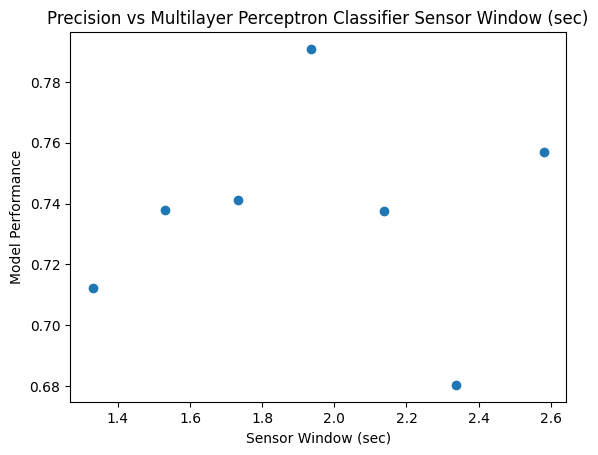

In [ ]:
plot_mods( fin_data, 'Multilayer Perceptron Classifier', 'weightedPrecision')

    Window_In_Seconds  metric_value  Data processing time  MLP training time
2            1.330313      0.705124             63.444786         127.558881
8            1.531875      0.727859             60.876517         114.311256
14           1.733437      0.736342             66.996111         199.762787
20           1.935000      0.783509             85.803353         165.335979
26           2.136563      0.727520             82.810969         139.618384
32           2.338125      0.669494             86.218546         142.008921
38           2.580000      0.747201            137.882538         198.049355


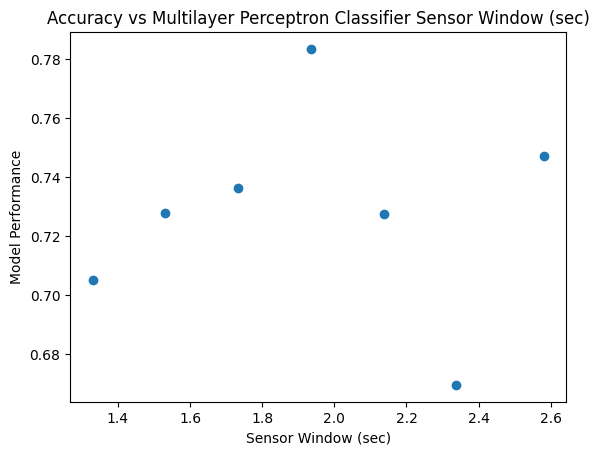

In [ ]:
plot_mods(fin_data, 'Multilayer Perceptron Classifier', 'accuracy')

    Window_In_Seconds  metric_value  Data processing time  MLP training time
1            1.330313      0.705124             63.444786         127.558881
7            1.531875      0.727859             60.876517         114.311256
13           1.733437      0.736342             66.996111         199.762787
19           1.935000      0.783509             85.803353         165.335979
25           2.136563      0.727520             82.810969         139.618384
31           2.338125      0.669494             86.218546         142.008921
37           2.580000      0.747201            137.882538         198.049355


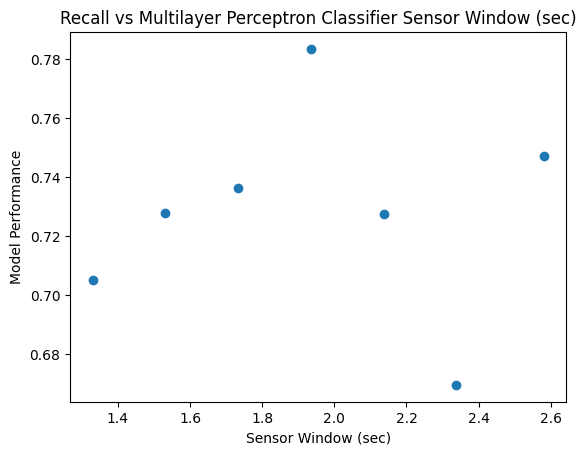

In [ ]:
plot_mods(fin_data, 'Multilayer Perceptron Classifier', 'weightedRecall')

    Window_In_Seconds  metric_value  Data processing time  MLP training time
3            1.330313      0.855073             63.444786         127.558881
9            1.531875      0.846729             60.876517         114.311256
15           1.733437      0.848794             66.996111         199.762787
21           1.935000      0.849050             85.803353         165.335979
27           2.136563      0.845540             82.810969         139.618384
33           2.338125      0.844099             86.218546         142.008921
39           2.580000      0.846759            137.882538         198.049355


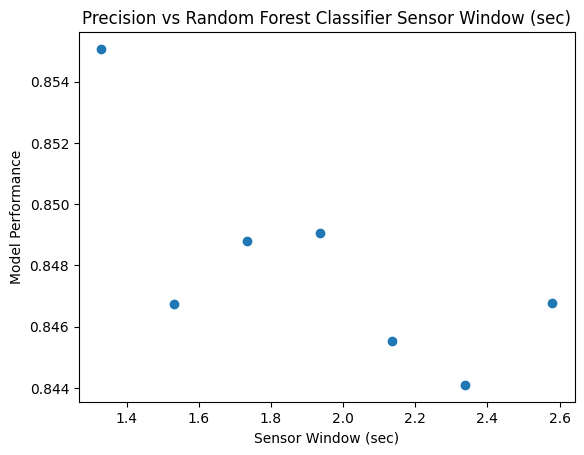

In [ ]:
plot_mods(fin_data, 'Random Forest Classifier', 'weightedPrecision')

    Window_In_Seconds  metric_value  Data processing time  MLP training time
5            1.330313      0.854768             63.444786         127.558881
11           1.531875      0.845266             60.876517         114.311256
17           1.733437      0.847981             66.996111         199.762787
23           1.935000      0.846963             85.803353         165.335979
29           2.136563      0.844248             82.810969         139.618384
35           2.338125      0.843230             86.218546         142.008921
41           2.580000      0.845945            137.882538         198.049355


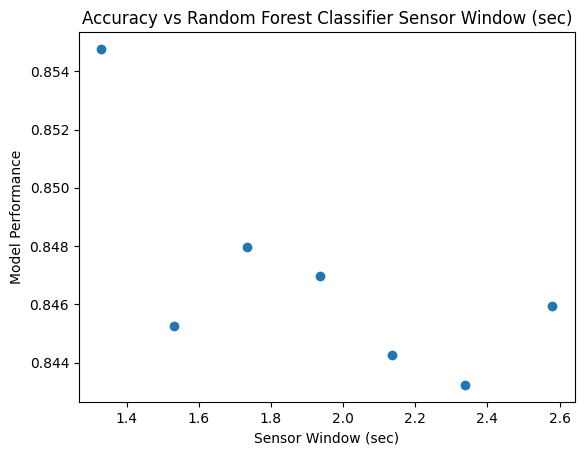

In [ ]:
plot_mods(fin_data, 'Random Forest Classifier', 'accuracy')

    Window_In_Seconds  metric_value  Data processing time  MLP training time
4            1.330313      0.854768             63.444786         127.558881
10           1.531875      0.845266             60.876517         114.311256
16           1.733437      0.847981             66.996111         199.762787
22           1.935000      0.846963             85.803353         165.335979
28           2.136563      0.844248             82.810969         139.618384
34           2.338125      0.843230             86.218546         142.008921
40           2.580000      0.845945            137.882538         198.049355


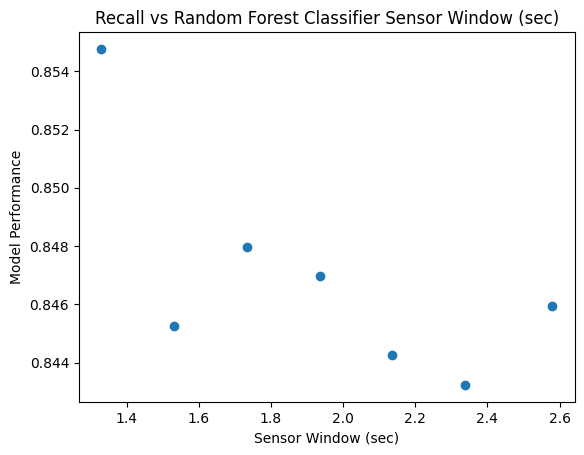

In [ ]:
plot_mods(fin_data, 'Random Forest Classifier', 'weightedRecall')

In [ ]:
# subset dataframe
times = fin_data.loc[fin_data['Evaluation_Type'] == 'accuracy']
times = times.loc[times['Model'] == 'Multilayer Perceptron Classifier']
times = times.iloc[:, [1,4,5,6]]
times

,Window_In_Seconds,RFC training time,Data processing time,MLP training time
2,1.330313,206.578496,63.444786,127.558881
8,1.531875,149.881168,60.876517,114.311256
14,1.733437,278.420608,66.996111,199.762787
20,1.935000,204.322461,85.803353,165.335979
26,2.136563,184.166690,82.810969,139.618384
32,2.338125,176.705015,86.218546,142.008921
38,2.580000,234.808546,137.882538,198.049355


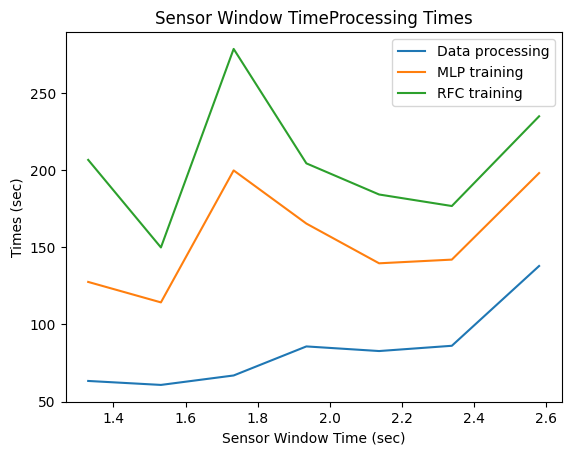

In [ ]:
# line 1 points
y1 = times['Data processing time']
x1 = times['Window_In_Seconds']
# plotting the line 1 points
plt.plot(x1, y1, label = "Data processing")

# line 2 points
y2 = times['MLP training time']
x2 = times['Window_In_Seconds']
# plotting the line 2 points
plt.plot(x2, y2, label = "MLP training")

# line 3 points
y3 = times['RFC training time']
x3 = times['Window_In_Seconds']
# plotting the line 3 points
plt.plot(x3, y3, label = "RFC training")

# naming the x axis
plt.ylabel('Times (sec)')
# naming the y axis
plt.xlabel('Sensor Window Time (sec)')
# giving a title to my graph
plt.title( 'Sensor Window Time' + 'Processing Times')

# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()

